# Example 1

## Problem

$$Min \int_0^{t_f}x\sqrt{1+u^2}dt\\
\dot{x} = u\\
u\in\R$$

In [2]:
# Packages

using Pkg
Pkg.activate(".")
#
using LinearAlgebra
using ForwardDiff
using DifferentialEquations
using Plots

#using MINPACK # NLE solver
using NLsolve
using LaTeXStrings
using Revise

  Activating project at `~/control-toolbox/indirect`


## Analytic solution
$$\tanh(\lambda) = x_0/p_0\\
\beta = x_0/\cosh(\lambda)\\
\alpha = -\lambda\beta\\
x(t,\lambda) = \beta\cosh((t-\alpha)/\beta)\\
p(t,\lambda) = \beta\sinh((t-\alpha)/\beta)
$$

Int_p_0 = 

[-0.99, -0.74, -0.49, -0.24, 0.01, 0.26, 0.51, 0.76]


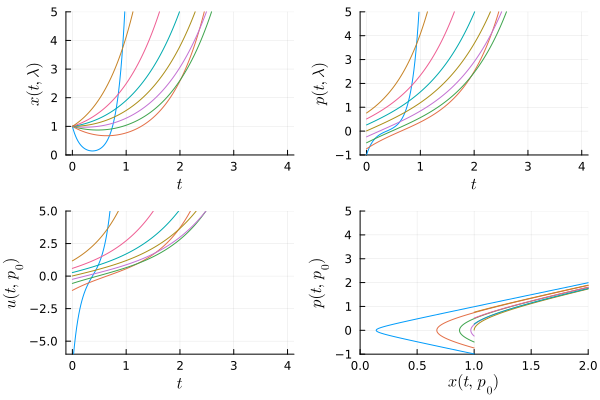

In [3]:
# state and costate solution
# par=-α/β
x₀ = 1.
t0 = 0.
tf = 4.
"""
   state
"""
function x(t,x₀,p0)
    λ = atanh(p0/x₀)
    β = x₀/cosh(λ)
    α = -λ*β
    return β*cosh((t-α)/β)
end
"""
   costate
"""
function p(t,x₀,p0)
    λ = atanh(p0/x₀)
    β = x₀/cosh(λ)
    α = -λ*β
    return β*sinh((t-α)/β)
end
"""
   control
"""
u(x, p) = sign(x[1])*p[1]*sqrt(1. /(x[1]^2-p[1]^2))

plt1_ana = plot()
plt2_ana = plot()
plt_phase_ana = plot()
plt3_ana = plot()

#Int_p_0 = -0.98:0.05:-0.3
Int_p_0 = -0.99:0.25:0.99
println("Int_p_0 = ", collect(Int_p_0))
#Int_p_0 = tanh.(-5:0.4:1)
for p0 in Int_p_0 #-5:0.4:1#0.1:0.1:0.1
    T = 0:0.02:tf
    X = x.(T,x₀,p0)
    P = p.(T,x₀,p0)
    plot!(plt1_ana,T,X)
    plot!(plt2_ana,T,P)
    plot!(plt_phase_ana,X,P)
    plot!(plt3_ana,T,u.(X,P))
end
plot!(plt1_ana,xlabel=L"t",ylabel=L"x(t,\lambda)",ylims=(0.,5.),legend=false)
plot!(plt2_ana,legend=false,xlabel=L"t",ylabel=L"p(t,\lambda)",ylims=(-1.,5.))
plot!(plt3_ana,xlabel = L"t",ylabel=L"u(t,p_0)",legend=false, ylims=(-6.,5.))
plot!(plt_phase_ana,xlabel = L"x(t,p_0)",ylabel=L"p(t,p_0)",legend=false, xlims=(0.,2.), ylims=(-1.,5.))
plot(plt1_ana,plt2_ana,plt3_ana,plt_phase_ana,layout=(2,2))

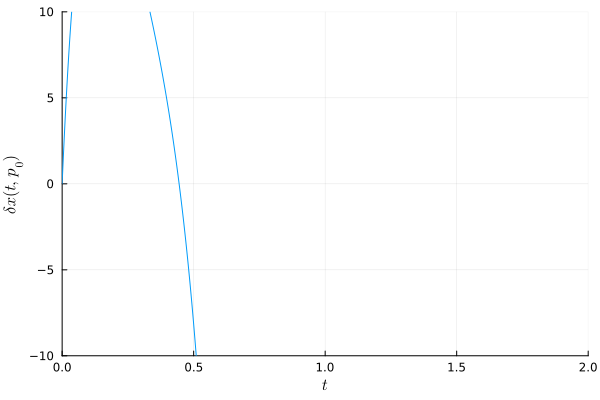

In [5]:
#
# Conjugate points
#
#
function jacobi(δz, par, t)
    x0, p0 = par   # (x_0,p_0)

    x_t = x(t,x0,p0)
    p_t = p(t,x0,p0)
    temp = 1/(x_t^2 - p_t^2)^(3/2)
    return temp*[-x_t*p_t x_t^2 ; -p_t^2 x_t*p_t]*δz
end

function flow_jacobi(t0tf,x0,p0)
    t0, tf = t0tf
    prob = ODEProblem(jacobi,[0;1],t0tf,[x0;p0])
    sol = DifferentialEquations.solve(prob,reltol = 1e-8, abstol = 1e-8) #DifferentialEquations.
    #return sol
end



#   Int_p_0 = -0.98:0.05:-0.3
Int_p_0 = -0.99
   t0tf = (0,2)
   plt4_ana = plot()
   for p0 in Int_p_0 #-5:0.4:1#0.1:0.1:0.1
       sol = flow_jacobi(t0tf,x₀,p0)
       #println(sol)
       plot!(plt4_ana,sol, idxs = (1))
   end

plot!(plt4_ana,xlabel = L"t",ylabel=L"\delta x(t,p_0)",legend=false, ylims=(-10.,10.))
plot(plt4_ana)


tau_0 = 0.4447237288858507
p0 = -0.99


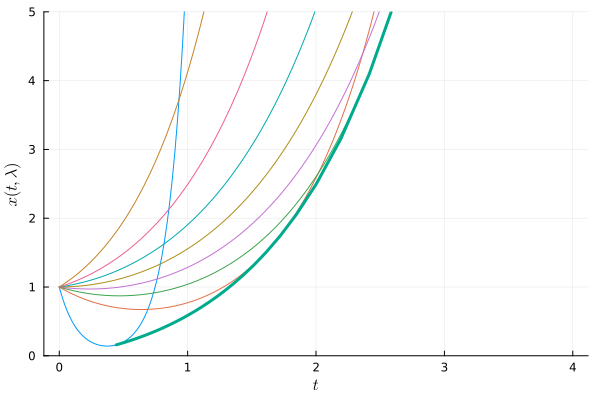

In [6]:
# compute the fisrt conjugate point
function F(τ,p0)
    tspan = (0,τ)
#    return [flow_jacobi(tspan,x₀,p0)(τ)[1]]
    return flow_jacobi(tspan,x₀,p0)(τ)[1] 
end

p0 = Int_p_0[1]


# compute τ₀
#Finit(τ) = F(τ[1],p0)
Finit(τ) = F(τ,p0)

#sol = nlsolve(Finit,[0.5])
using Roots
#τ₀ = sol.zero
τ₀ = find_zero(Finit, (0.4, 0.5))
println("tau_0 = ", τ₀)

#
function rhs_path(tau, par, p0)
    τ = tau[1]
    #Fp0(τ) = F(τ, p0)
    Ftau(p0) = F(τ, p0)
    δz = flow_jacobi((0,τ),x₀,p0)(τ)
    derivee_τ = jacobi(δz, [x₀,p0], τ)[1]
    derivee_p0 = ForwardDiff.derivative(Ftau, p0)
    #println("Ftau(p0) = ", -(1/derivee_τ)*derivee_p0)
    return [-(1/derivee_τ)*derivee_p0]
end

function conj_point(p0span, τ₀)
    pb = ODEProblem(rhs_path,τ₀,p0span)
    sol = solve(pb, reltol = 1e-8, abstol = 1e-8)
    return sol
end

# conjugate point

println("p0 = ", p0)

p0span = (p0, -0.5)
sol = conj_point(p0span,[τ₀])
plt_conj_point = plot(sol,xlabel = L"p\_0", ylabel = L"\tau")
TT = sol.u
nb_t = length(sol.t)
T = zeros(nb_t)
X = zeros(nb_t)
for i in 1:nb_t
    #println(T[i])
    #println(sol.t[i])
    T[i] = TT[i][1]
    X[i] = x(T[i][1],x₀,sol.t[i])
end

plot!(plt1_ana,T,X,linewidth=3)

In [7]:
size(T)


(33,)

In [8]:
ff(x,par,t ) = x

function FF(tf)
prob = ODEProblem(ff,[1.],(0.,tf))
sol = solve(prob)[:,end][1]
return sol
end

println("FF = ", FF(2))
ForwardDiff.derivative(FF,1.)


FF = 7.389050121897669


OrdinaryDiffEq.TypeNotConstantError: Detected non-constant types in an out-of-place ODE solve, i.e. for
`du = f(u,p,t)` we see `typeof(du) !== typeof(u/t)`. This is not
supported by OrdinaryDiffEq.jl's solvers. Please either make `f`
type-constant (i.e. typeof(du) === typeof(u/t)) or use the mutating
in-place form `f(du,u,p,t)` (which is type-constant by construction).

Note that one common case for this is when computing with GPUs, using
`Float32` for `u0` and `Float64` for `tspan`. To correct this, ensure
that the element type of `tspan` matches the preferred compute type,
for example `ODEProblem(f,0f0,(0f0,1f0))` for `Float32`-based time.

typeof(u/t) = Vector{ForwardDiff.Dual{ForwardDiff.Tag{typeof(FF), Float64}, Float64, 1}}
typeof(du) = Vector{Float64}
